## Imports

In [45]:
import pandas as pd
import time

from tqdm.auto import tqdm
tqdm.pandas()

In [46]:
!pip install onnx onnxruntime optimum[onnxruntime]

## Validation data

In [47]:
from typing import List

def metrics(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn = 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        tp += len(set(y_true_sample) & set(y_pred_sample))
        fp += len(set(y_pred_sample) - set(y_true_sample))
        fn += len(set(y_true_sample) - set(y_pred_sample))
    
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0 if tp + fn != 0.0 else 1.0
    recall = tp / (tp + fn) if tp + fn != 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [48]:
uk_geo_df = pd.read_csv("/kaggle/input/uk-ner-multibert/uk_geo_dataset_light.csv", converters={"loc_markers": eval})
ru_geo_df = pd.read_csv("/kaggle/input/multibert-ru/ru_geo_dataset_light.csv", converters={"loc_markers": eval})

In [49]:
uk_geo_valid = uk_geo_df[uk_geo_df['is_valid'] == 1].copy()
ru_geo_valid = ru_geo_df[ru_geo_df['is_valid'] == 1].copy()
del uk_geo_df, ru_geo_df

In [50]:
def convert_loc_markers(row):
    text = row['text']
    markers = row['loc_markers']

    locs = []
    for m in markers:
        locs.append(text[m[0]:m[1]])
    
    return locs 

In [51]:
uk_geo_valid['locations'] = uk_geo_valid.progress_apply(convert_loc_markers, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
ru_geo_valid['locations'] = ru_geo_valid.progress_apply(convert_loc_markers, axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: xlabel='locations'>

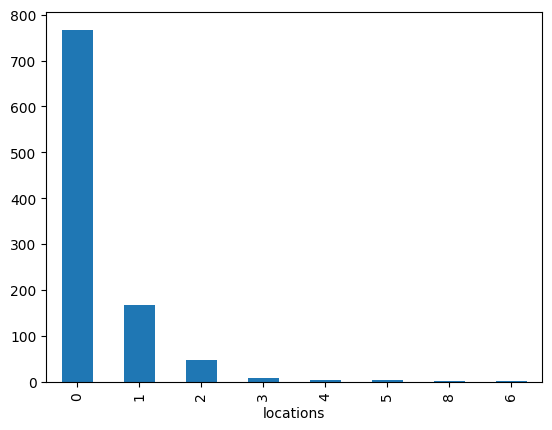

In [53]:
uk_geo_valid['locations'].apply(len).value_counts().plot.bar()

## UK model

In [54]:
stats = []

In [55]:
from transformers import pipeline

In [56]:
stats_plain = {}
stats_plain['model'] = 'uk_plain'
model_uk = "/kaggle/input/uk-ner-multibert/bert-ua-loc-ner/checkpoint-14096"
classifier_uk = pipeline("token-classification", model=model_uk, aggregation_strategy="simple")

In [57]:
start = time.time()
preds = classifier_uk(uk_geo_valid['text'].to_list())
stats_plain['time'] = time.time() - start

In [58]:
preds_locations = []
for pred in preds:
    locs = []
    for loc in pred:
        locs.append(loc['word'])
    preds_locations.append(locs)

In [59]:
uk_geo_valid['locations_pred'] = preds_locations

In [60]:
stats_plain.update(metrics(uk_geo_valid['locations'], uk_geo_valid['locations_pred']))

In [61]:
stats_plain

{'model': 'uk_plain',
 'time': 113.31898784637451,
 'precision': 0.8380681818181818,
 'recall': 0.8832335329341318,
 'f1': 0.8600583090379008}

In [62]:
stats.append(stats_plain)

In [63]:
pd.DataFrame.from_records(stats)

,model,time,precision,recall,f1
0,uk_plain,113.318988,0.838068,0.883234,0.860058


### ONNX Conversion

In [64]:
from optimum.onnxruntime import ORTModelForTokenClassification
from transformers import AutoTokenizer

save_directory = "/kaggle/working/model_uk_onnx"

# Load a model from transformers and export it to ONNX
ort_model = ORTModelForTokenClassification.from_pretrained(model_uk, export=True)
tokenizer = AutoTokenizer.from_pretrained(model_uk)

# Save the onnx model and tokenizer
ort_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.
Using framework PyTorch: 2.0.0+cpu
Overriding 1 configuration item(s)
	- use_cache -> False


============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



('/kaggle/working/model_uk_onnx/tokenizer_config.json',
 '/kaggle/working/model_uk_onnx/special_tokens_map.json',
 '/kaggle/working/model_uk_onnx/vocab.txt',
 '/kaggle/working/model_uk_onnx/added_tokens.json',
 '/kaggle/working/model_uk_onnx/tokenizer.json')

In [65]:
from optimum.pipelines import pipeline
from optimum.onnxruntime import ORTModelForTokenClassification

In [66]:
model = ORTModelForTokenClassification.from_pretrained("/kaggle/working/model_uk_onnx")
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/model_uk_onnx")

In [67]:
classifier_uk = pipeline("token-classification", model=model, tokenizer=tokenizer, accelerator="ort", aggregation_strategy="simple")

In [68]:
stats_onnx = {}
stats_onnx['model'] = 'uk_onnx'

In [69]:
start = time.time()
preds = classifier_uk(uk_geo_valid['text'].to_list())
stats_onnx['time'] = time.time() - start

In [70]:
preds_locations = []
for pred in preds:
    locs = []
    for loc in pred:
        locs.append(loc['word'])
    preds_locations.append(locs)

In [71]:
uk_geo_valid['locations_pred_onnx'] = preds_locations

In [72]:
stats_onnx.update(metrics(uk_geo_valid['locations'], uk_geo_valid['locations_pred_onnx']))

In [73]:
stats.append(stats_onnx)

In [74]:
pd.DataFrame.from_records(stats)

,model,time,precision,recall,f1
0,uk_plain,113.318988,0.838068,0.883234,0.860058
1,uk_onnx,68.692958,0.838068,0.883234,0.860058


### Quantization